# Portfolio Choice 2

This notebook solves a portfolio optimization problem with several risky assets. The objective function of the investor trades off the portfolio expected return and variance.

## Load Packages

In [1]:
using Dates, LinearAlgebra           

include("jlFiles/printmat.jl")
include("jlFiles/printTable.jl")

printblue(txt) = printstyled(string(txt,"\n"),color=:blue,bold=true)  #blue, bold, newline

printblue (generic function with 1 method)

In [2]:
using Plots

#pyplot(size=(600,400))            #pyplot() or gr()
gr(size=(480,320))
default(fmt = :svg) 

# From Chapter on Mean-Variance Analysis

The file included below contains the functions `MVCalc()`, `MVCalcRf()` and `MVTangencyP()` from the chapter on MV analysis.

In [3]:
include("jlFiles/MvCalculations.jl")

MVTangencyP

# Optimal Portfolio Choice

An investor who maximizes

$\text{E}U(R_{p})   =\text{E}R_{p}-\frac{k}{2} \text{Var}(R_{p})$,

subject to 

$R_{p} = v'R^e + R_f$

will pick the portfolio weights (on the risky assets)

$v  =\frac{1}{k}\Sigma^{-1}\mu^{e}$

The portfolio weight on the riskfree asset is $1-\mathbf{1}'v$

In [4]:
"""
Calculate optimal portfolio weights
"""
function OptimalPortfolio(μ,Σ,Rf,k)           
    μᵉ    = μ .- Rf                           #expected excess returns            
    v     = inv(Σ) * μᵉ/k                     #optimal weights risky assets, 1-sum(v) in riskfree   
    mup   = v'μ + (1-sum(v))*Rf               #expected return and std of optimal portfolio
    StdRp = sqrt(v'Σ*v)
    return v,mup,StdRp
end 

OptimalPortfolio

## An Example with 2 Risky Assets (and a Riskfree)

In [5]:
μ = [8.5; 6.5]/100                     #means
Σ = [ 166  34;                         #covariance matrix 
      34    64]/100^2
Rf = 0.03                              #riskfree rate
n  = length(μ)                         #number of risky assets

2

In [6]:
k = 9
vOpt, = OptimalPortfolio(μ,Σ,Rf,k)         #find optimal portfolio

rowNames = ["Asset 1","Asset 2","Riskfree"]

printblue("optimal portfolio weights on risky assets and riskfree when k = $k:")
printTable([vOpt;(1-sum(vOpt))],[""],rowNames)

printblue("optimal portfolio weights on risky assets/their sum:")
printTable(vOpt/sum(vOpt),[""],rowNames[1:n])

wT, = MVTangencyP(μ,Σ,Rf)
printblue("Tangency portfolio:")
printTable(wT,[""],rowNames[1:n])

optimal portfolio weights on risky assets and riskfree when k = 9:
                  
Asset 1      0.273
Asset 2      0.462
Riskfree     0.264

optimal portfolio weights on risky assets/their sum:
                 
Asset 1     0.372
Asset 2     0.628

Tangency portfolio:
                 
Asset 1     0.372
Asset 2     0.628



## An Example with 3 Risky Assets  (and a Riskfree)

In [7]:
μ = [11.5; 9.5; 6]/100          
Σ  = [166  34  58;              
       34  64   4;
       58   4 100]/100^2                  
Rf = 0.03
n  = length(μ)

3

In [8]:
(vD,muD,StdD) = OptimalPortfolio(μ,Σ,Rf,28)        #high risk aversion
(vE,muE,StdE) = OptimalPortfolio(μ,Σ,Rf,8.8)       #low risk aversion

(wT,muT,StdT) = MVTangencyP(μ,Σ,Rf)                #tangency portfolio

rowNames = ["Asset 1","Asset 2","Asset 3","Riskfree"]

printblue("optimal portfolio weights")
xx = hcat([vD;(1-sum(vD))],[vE;(1-sum(vE))])
printTable(xx,["D","E"],rowNames)

printblue("optimal weights/tangency portfolio")
xx = [vD vE]./wT
printTable(xx,["D","E"],rowNames)

optimal portfolio weights
                 D         E
Asset 1      0.110     0.350
Asset 2      0.302     0.962
Asset 3      0.031     0.099
Riskfree     0.556    -0.411

optimal weights/tangency portfolio
                 D         E
Asset 1      0.444     1.411
Asset 2      0.444     1.411
Asset 3      0.444     1.411



In [9]:
μstar = range(Rf,stop=0.15,length=101)
L     = length(μstar)

StdRp = fill(NaN,(L,2))                 #loop over required average returns (μstar)
for i = 1:L
    StdRp[i,1] = MVCalc(μstar[i],μ,Σ)[1]           #risky only
    StdRp[i,2] = MVCalcRf(μstar[i],μ,Σ,Rf)[1]      #risky and riskfree
end

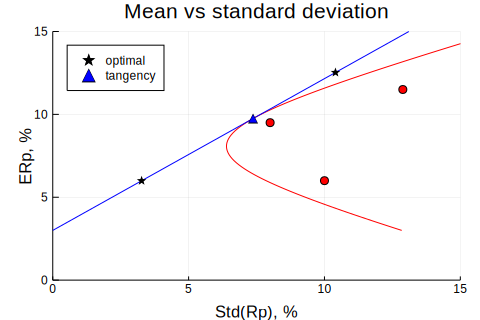

In [10]:
p1 = plot(StdRp[:,1]*100,μstar*100,label="",color=:red,xlim=(0,15),ylim=(0,15))
plot!(StdRp[:,2]*100,μstar*100,label="",color=:blue)
scatter!(sqrt.(diag(Σ))*100,μ*100,color=:red,label="")
scatter!([StdD,StdE]*100,[muD,muE]*100,color=:black,marker=:star,label="optimal")
scatter!([StdT]*100,[muT]*100,color=:blue,marker=:utriangle,label="tangency",legend=:topleft)
title!("Mean vs standard deviation")
xlabel!("Std(Rp), %")
ylabel!("ERp, %")

# Maximising the Sharpe Ratio (extra)

The following cell defines the Sharpe ratio on a portfolio where the portfolio weights on the $n$ risky assets sum to one. The optimization is over the $n-1$ first weights.

The ```Optim``` package is used for the optimisation.

In [11]:
using Optim

In [12]:
function SRFn(w,μ,Σ,Rf)
    v     = [w;1-sum(w)]
    μᵉ    = μ .- Rf                             #expected excess returns            
    muep  = v'μᵉ
    StdRp = sqrt(v'Σ*v)
    SRp   = muep/StdRp
    return SRp  
end    

SRFn (generic function with 1 method)

In [13]:
Sol = optimize(w -> -SRFn(w,μ,Σ,Rf),zeros(2))     #maximise SR

v = Optim.minimizer(Sol)
v = [v;1-sum(v)]

println("Tangency and optimal")
printmat([wT v])

Tangency and optimal
     0.248     0.248
     0.682     0.682
     0.070     0.070

